#EX4


## Write your id numbers and names here


1.   Etay Lorberboym - 314977596
2.   Peleg Gitnik - 208816827


###Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neural_network

In [58]:
import warnings
warnings.filterwarnings('ignore')

##Loading the data

In [2]:
df = pd.read_csv('/content/ex4_data.csv')

Firtsly, we would want to have a look over the data

In [3]:
df.head()

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,RACE_BLACK,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,False,60,False,True,True,False,False,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,False,75,False,False,False,False,True,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,False,62,False,False,False,False,False,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,False,75,True,False,False,False,True,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,False,81,False,False,False,False,True,WHITE,126,108,39,84,28.78,36.660286,False,1,False


In [4]:
df.shape

(8746, 30)

We can see the dimenssions of the data.
We have 8746 rows and 30 columns

In [5]:
df.isnull().sum()

INTENSIVE               0
NEWSITEID             465
RISK10YRS               0
INCLUSIONFRS            0
SBP                     0
DBP                     0
N_AGENTS                0
NOAGENTS                0
SMOKE_3CAT              0
ASPIRIN                 0
EGFR                    0
SCREAT                  0
SUB_CKD                 0
RACE_BLACK              0
AGE                     0
FEMALE                  0
SUB_CVD                 0
SUB_CLINICALCVD         0
SUB_SUBCLINICALCVD      0
SUB_SENIOR              0
RACE4                   0
CHR                     0
GLUR                    0
HDL                     0
TRR                     0
UMALCR                  0
BMI                     0
STATIN                  0
SBPTERTILE              0
EVENT_PRIMARY           0
dtype: int64

As we can see only in the NEWSITEID column we have 465 null values which means we dont know the site ID that the participant was treated in.
We would not want to loose information by removing those rows, so we will convert each null value to 0 so we can use this information for our model.

Now when we will classify a new patient we will use this information as class 0 (meaning we don't know where was the patient diagnosed) to add more information.

For example it can help us learn a pettern of the pateints that we don't know where they are diagnosed, maybe most of them died because they were treated in bad places that are usally dont fill this information, or maybe the opposite.

In [6]:
df['NEWSITEID'] = df['NEWSITEID'].fillna(0)

In [7]:
df['NEWSITEID'].isnull().sum()

0

Now we can see there is no Null values left.

####Split data to X and y

In [8]:
#split data to X and y 
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

Let's look over the count of the target variable, to see how many patients were died/had a cardiover event 

False    8207
True      539
Name: EVENT_PRIMARY, dtype: int64


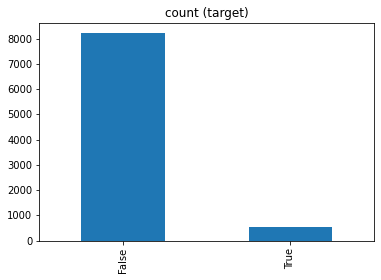

In [9]:
print(df['EVENT_PRIMARY'].value_counts())
df['EVENT_PRIMARY'].value_counts().plot(kind = 'bar', title='count (target)')

We can see from the plot that we have imbalanced classes situation where the True value representing the patients that were died is much lower that the number of patients that did not die.
This can affect our models by classifing all the patients to not having the event, meaning that patients that are about to die would be classified to be healthy.

<u>Note </u>:

We discovered it after running the models and realizing that the models that recieved the highest accuracy classifed all the patients to False.



To handle this situation we would use over-smapling technique to increase the number of samples with True target value.
We will do that by generate new samples in the minority class.

We would apply the oversampling after splitting the data to train and test that we will not replecate samples of the test data.

We can see now that we have an equal number of samples both from the True output and the False output.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INTENSIVE           8746 non-null   object 
 1   NEWSITEID           8746 non-null   float64
 2   RISK10YRS           8746 non-null   float64
 3   INCLUSIONFRS        8746 non-null   bool   
 4   SBP                 8746 non-null   int64  
 5   DBP                 8746 non-null   int64  
 6   N_AGENTS            8746 non-null   int64  
 7   NOAGENTS            8746 non-null   bool   
 8   SMOKE_3CAT          8746 non-null   int64  
 9   ASPIRIN             8746 non-null   bool   
 10  EGFR                8746 non-null   float64
 11  SCREAT              8746 non-null   float64
 12  SUB_CKD             8746 non-null   bool   
 13  RACE_BLACK          8746 non-null   bool   
 14  AGE                 8746 non-null   int64  
 15  FEMALE              8746 non-null   bool   
 16  SUB_CV

As we can see from the info function most of the data is numeric but we have some columns where the data is boolean and some columns that the data is of type object (string).
We will use label encoding for the boolean types collumns.
We will use the OneHotEncoder object from Sklearn to encode the values that are not numeric.

<u>Note:</u> We will not encode the boolean values beacuse in python False = 0 and True = 1, so we can use them as it is in the model.

In [11]:
X[0]

array(['Regular', 74.0, 29.7320614813495, True, 145, 80, 2, False, 3,
       True, 67.69, 1.11, False, False, 60, False, True, True, False,
       False, 'WHITE', 155, 81, 36, 92, 5.8, 33.115200556984895, True, 3],
      dtype=object)

In [12]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,20])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [13]:
X[0]

array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 74.0, 29.7320614813495, True, 145,
       80, 2, False, 3, True, 67.69, 1.11, False, False, 60, False, True,
       True, False, False, 155, 81, 36, 92, 5.8, 33.115200556984895, True,
       3], dtype=object)

We will use train test split to evaluate the model.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

Now we would apply the oversampling

In [15]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_test, y_test = ros.fit_resample(X_test, y_test)

As we can see from the first sample, there are values that range with bigger values then most of the columns that range between 0 to 1, this can affect our models predictions.

Because of that, we will apply Standartization for the data. 
We would apply the Standartization over the train data (calculate the mean and std of the train and then do the Standartization with those parameters) and then we will transform the test data.

We will not standartize the dummy variables,SBPTERTILE and SMOKE_3CAT columns beacuse doing so will not add more inforamtion.
The columns of SMOKE_3CAT and SBPTERTILE are ordinal categories that are already encoded, so the standartization of those varibales will not add information to the model.

 


In [16]:
#Saving copy of the data for later.
X_train_later = X_train.copy()

In [17]:
#note -- to do standartization only for the train data
sc = StandardScaler()
X_train[:,[6,7,9,10,11,15,16,19,25,26,27,28,29,30]] = sc.fit_transform(X_train[:,[6,7,9,10,11,15,16,19,25,26,27,28,29,30]]) 
X_test[:,[6,7,9,10,11,15,16,19,25,26,27,28,29,30]] = sc.transform(X_test[:,[6,7,9,10,11,15,16,19,25,26,27,28,29,30]]) 

In [18]:
X_train[0]

array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, -0.8211564354099522,
       0.059601830363463226, True, 0.027786731634730045,
       -1.4610322321074254, 1.9928418091560098, False, 2, True,
       0.9713582728146898, -0.7521208194898559, False, False,
       0.5120515742763362, False, False, False, False, True,
       -0.29731412478045727, 1.203137630685182, 0.44028755713343354,
       0.8275316784786315, -0.15690245531715, -0.620051221610488, True, 2],
      dtype=object)

Now we can see that we have all the values normalized and readly to work on.

####Hypothesis and metrics for evaluation


Because our data is sensitive, our main metric would be the Recall value (sensitivity) to compare between the models.

We prefer classifing a patient to True - meaning he is going to die over labling a patient in real risk as healthy.

To maximaize the sensitivity (True positive rate) value and minimize False positive rate we will perform a grid search to evaluate the models with roc - auc score.

This metric will try to make sure we dont miss people that are not healthy and will try to minimize the amount of true predictions for people that are healthy.


###First Model - Linear Classifier

For the first linear model we choose the Logistic Regression model.

We will use grid search to find the best parameters that will maximaize the model performance.



####Logistic regression

In [ ]:
#define grid search for optimal parameters
grid_logReg={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state = 0, max_iter=500)
logreg_cv=GridSearchCV(logreg,grid_logReg,  scoring='roc_auc')
logreg_cv.fit(X_train,y_train)

In [20]:
#Best parameters found
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("AUC Score:",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
AUC Score: 0.7253993705013567


In [21]:
y_pred_log_reg = logreg_cv.predict(X_test)
log_report = classification_report(y_pred_log_reg, y_test)
print('Logistic Regression report score: \n',log_report)

Logistic Regression report score: 
               precision    recall  f1-score   support

       False       0.70      0.63      0.66      2985
        True       0.60      0.66      0.63      2435

    accuracy                           0.65      5420
   macro avg       0.65      0.65      0.65      5420
weighted avg       0.65      0.65      0.65      5420



We can notice that we recieved an AUC score of 0.72 with the tuned parameters we found (C:100 and penalty is l2).

Moreover, we can notice that the model return results for all the other metrics of 0.65 (average).

###Second Model - Ensemble Model

There are 3 types of ensemble method we learned in class:
1. Boosting
2. Bagging
3. Stacking

For this exercise we choose to use the AdaBoost model with decision trees as weak leraners.

We believe the boosting method will give us the best results because the weak learners transfer between each other the data that misscalssifed and tries to improve it.



In [ ]:
grid_adb = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']}

DTC = DecisionTreeClassifier()
adb = AdaBoostClassifier(base_estimator = DTC)

grid_search_adb = GridSearchCV(adb, param_grid=grid_adb, scoring = 'roc_auc')
grid_search_adb.fit(X_train, y_train)

In [23]:
#Best parameters found
print("tuned hpyerparameters :(best parameters) ",grid_search_adb.best_params_)
print("AUC Score:", grid_search_adb.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'SAMME.R', 'learning_rate': 1.04, 'n_estimators': 5}
AUC Score: 0.9653469269583919


In [24]:
y_adb = grid_search_adb.predict(X_test)
print(f'AdaBoost report score:\n {classification_report(y_adb, y_test)}')

AdaBoost report score:
               precision    recall  f1-score   support

       False       0.93      0.51      0.66      4982
        True       0.10      0.59      0.17       438

    accuracy                           0.52      5420
   macro avg       0.52      0.55      0.41      5420
weighted avg       0.87      0.52      0.62      5420



We can notice a recall score of 0.62 and a AUC score of 0.96

###Third Model - Deep Learning Model

For the Deep learning part we will build a Nueral Network with the Sklearn library (we tried to build the NN with keras but the Grid search optimization is more convient using the Sklearn library).

We will compare the results using the GRid search for optimzing the parameters of the NN.

In [ ]:
#Define grid for Neural Network
NN_grid = {'solver': ['adam', 'sgd'],
              'activation': ['logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':np.arange(5, 7),
              'max_iter': [500,1000],
              'learning_rate': ['constant', 'adaptive']}
#Apply Grid serach           
NN_clf = GridSearchCV(neural_network.MLPClassifier(), NN_grid, scoring='roc_auc')  
NN_clf.fit(X_train, y_train)         

In [26]:
#Best parameters found
print("tuned hpyerparameters :(best parameters) ", NN_clf.best_params_)
print("AUC Score:", NN_clf.best_score_)

tuned hpyerparameters :(best parameters)  {'activation': 'tanh', 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
AUC Score: 0.8312034717338671


In [80]:
y_NN = NN_clf.predict(X_test)
print(f'Nueral Network report score:\n {classification_report(y_NN, y_test)}')

Nueral Network report score:
               precision    recall  f1-score   support

       False       0.71      0.58      0.64      3326
        True       0.48      0.62      0.54      2094

    accuracy                           0.60      5420
   macro avg       0.60      0.60      0.59      5420
weighted avg       0.62      0.60      0.60      5420



We can see that the Recall score for True is 0.63 and the AUC score is 0.82

##Theortical Questions

1 . 
For each model, does the model overfit?

2.In the DL model, what's the effect of batch size? In general, and do you see this effect in the current task?

#####Answer 1

To answer the first question we will try to see if the model is learned the training set to well and recieved bad results for the test set.
We will do so by trying to evaluate the training set comparing to the evaulation of the testing test.
If the results will have a big diffrence in favor of the training set, we could say that our models tend to overfit.
We will do the comparison with a function.
The comparison will be with accuarcy score.

In [28]:
def measure_overfit(model , X_train, X_test, y_train, y_test):
  y_model_train = model.predict(X_train)
  y_model_test = model.predict(X_test)
  acc_train = accuracy_score(y_model_train, y_train)
  acc_test = accuracy_score(y_model_test, y_test)
  return acc_train,acc_test

In [29]:
print('Linear model results:')
linear_m = measure_overfit(logreg_cv , X_train, X_test, y_train, y_test)
print(f'Train accuracy = {linear_m[0]} Test accuarcy = {linear_m[1]} \n')
print('Ensemble model results:')
ensemble_m = measure_overfit(grid_search_adb , X_train, X_test, y_train, y_test)
print(f'Train accuracy = {ensemble_m[0]} Test accuarcy = {ensemble_m[1]} \n')
print('Deep Learning model results:')
DL_m = measure_overfit(NN_clf , X_train, X_test, y_train, y_test)
print(f'Train accuracy = {DL_m[0]} Test accuarcy = {DL_m[1]}')

Linear model results:
Train accuracy = 0.6600873203565581 Test accuarcy = 0.6474169741697416 

Ensemble model results:
Train accuracy = 1.0 Test accuarcy = 0.5151291512915129 

Deep Learning model results:
Train accuracy = 0.7781517191195197 Test accuarcy = 0.596309963099631


We can see that the Linear model does not tend to overfit as the train and test results are almost similiiar (0.65 and 0.64).

The ensemble model has overfit as the accuracy level for train is 1 and for test is 0.52

The Deep learning also have overfit beacuse of the big diffrence in the results 0.77 compare to 0.59

#####Answer 2

To measure the affect of the batch size over the Deep Learning model we will try to use diffrent batch size and compare the results.

We will use the Grid search function again to check the results.

In [ ]:
NN_grid_batch = {'batch_size': [1,10,20,50,100,500]}
NN_clf_batch = GridSearchCV(neural_network.MLPClassifier(), NN_grid_batch, scoring='accuracy')  
NN_clf_batch.fit(X_train,y_train)         

In [31]:
def print_grid_results(model, batches):
  for i in range(len(batches)):
    scores = model.cv_results_['mean_test_score']
    print(f'Deep Learning model with batch = {batches[i]} score = {scores[i]}')

In [32]:
batches = [1,10,20,50,100,500]
print_grid_results(NN_clf_batch, batches)

Deep Learning model with batch = 1 score = 0.9490635788208802
Deep Learning model with batch = 10 score = 0.9600695741839805
Deep Learning model with batch = 20 score = 0.9695292880666659
Deep Learning model with batch = 50 score = 0.9634353194706338
Deep Learning model with batch = 100 score = 0.9616159798005628
Deep Learning model with batch = 500 score = 0.9460615938835628


We can see that changing the batch size didnt have a significance affect over the accuracy level of the model.

We still have some kind of an overfit for the model evaluation when we change the batch size.

###Comparison between our models:



We added more comaprison between the model threw diffrent metrics to try to find the one that will handle the data best as possible. 

**Let's look over the ROC curve measure and the AUC score:**

In [33]:
# apply in the comparison part seaborn package.
import seaborn as sns
sns.set_theme(style="whitegrid")

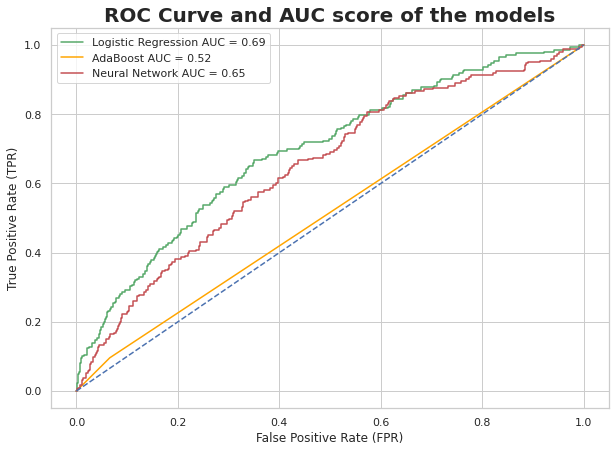

In [87]:
from sklearn.metrics import auc

# Logistic:
y_score_log = logreg_cv.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
auc_log = auc(fpr_log, tpr_log)

# AdaBoost:
y_score_adb = grid_search_adb.predict_proba(X_test)[:, 1]
fpr_adb, tpr_adb, _ = roc_curve(y_test, y_score_adb)
auc_adb = auc(fpr_adb, tpr_adb)

# NN:
y_score_nn = NN_clf.predict_proba(X_test)[:, 1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(10,7))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression AUC = {round(auc_log, 2)}', color="g")
plt.plot(fpr_adb, tpr_adb, label=f'AdaBoost AUC = {round(auc_adb, 2)}', color="orange")
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network AUC = {round(auc_nn, 2)}', color="r")
plt.plot([0, 1], "--", color="b")

plt.title('ROC Curve and AUC score of the models', fontweight ='bold',fontsize = 20)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

The calculated value of the AUC for each model is the area under his curve. We got different results here than we expected. We wanted to check the AUC score of each model over the test data. We can see much lesser AUC score in comparison to the train data (we calculated earlier). For example over the NN we got 0.83 over train and now 0.65 over test. It shows that our models maybe tend to be overfitting (over test the classifiers didn't get so well results and over the train they did). In this case the model that performed the best is the Logistic model with 0.69, and the worst of them is the AdaBoost with 0.52 (with AUC score almost random).

**We would like to compare the metrics of the models for each label separately:**

(We will start with: F1-score, Precision and recall metrics).

In [48]:
log_report = classification_report(y_pred_log_reg, y_test, output_dict=True)
adb_report = classification_report(y_adb, y_test, output_dict=True)
nn_report = classification_report(y_test, y_NN, output_dict=True)

lst_true = [log_report['True'], adb_report['True'], nn_report['True']]
lst_false = [log_report['False'], adb_report['False'], nn_report['False']]

recall = {'Logistic Regression': log_report['True']['recall'], 'AdaBoost': adb_report['True']['recall'], 'Neural Network': nn_report['True']['recall']}
sorted_recall = sorted(recall.items(), key=lambda item: item[1], reverse=True)

accuracy_scores = {'Logistic Regression': log_report['accuracy'], 'AdaBoost': adb_report['accuracy'], 'Neural Network': nn_report['accuracy']}
sorted_acc_score = sorted(accuracy_scores.items(), key=lambda item: item[1], reverse=True)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
true_f1 = [lst_true[0]['f1-score'], lst_true[1]['f1-score'], lst_true[2]['f1-score']]
true_prec = [lst_true[0]['precision'], lst_true[1]['precision'], lst_true[2]['precision']]
true_recall = [lst_true[0]['recall'], lst_true[1]['recall'], lst_true[2]['recall']]

false_f1 = [lst_false[0]['f1-score'], lst_false[1]['f1-score'], lst_false[2]['f1-score']]
false_prec = [lst_false[0]['precision'], lst_false[1]['precision'], lst_false[2]['precision']]
false_recall = [lst_false[0]['recall'], lst_false[1]['recall'], lst_false[2]['recall']]


# Set position of bar on X axis
br1 = np.arange(len(true_f1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

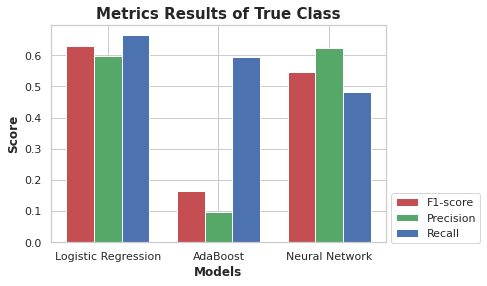

In [50]:
# Make the plot
plt.bar(br1, true_f1, color ='r', width = barWidth,
        edgecolor ='white', label ='F1-score')
plt.bar(br2, true_prec, color ='g', width = barWidth,
        edgecolor ='white', label ='Precision')
plt.bar(br3, true_recall, color ='b', width = barWidth,
        edgecolor ='white', label ='Recall')


# Adding Xticks
plt.title('Metrics Results of True Class', fontweight ='bold', fontsize = 15)
plt.xlabel('Models', fontweight ='bold', fontsize = 12)
plt.ylabel('Score', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(true_f1))],
        ['Logistic Regression', 'AdaBoost', 'Neural Network'])

# plt.grid(color='w', linestyle='solid')
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.show()

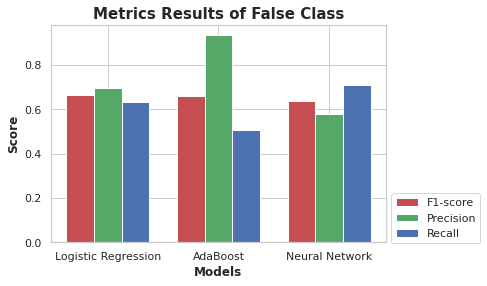

In [51]:
# Make the plot
plt.bar(br1, false_f1, color ='r', width = barWidth,
        edgecolor ='white', label ='F1-score')
plt.bar(br2, false_prec, color ='g', width = barWidth,
        edgecolor ='white', label ='Precision')
plt.bar(br3, false_recall, color ='b', width = barWidth,
        edgecolor ='white', label ='Recall')
 
# Adding Xticks
plt.title('Metrics Results of False Class', fontweight ='bold', fontsize = 15)
plt.xlabel('Models', fontweight ='bold', fontsize = 12)
plt.ylabel('Score', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(false_f1))],
        ['Logistic Regression', 'AdaBoost', 'Neural Network'])

# plt.grid(color='w', linestyle='solid')
plt.legend(loc='best', bbox_to_anchor=(1, 0.25))
plt.show()

As we said before about the importnace of Classify as many as we can in the correct classification for True label (Recall). So, we would especially like to focus on this metric (Recall) for a True label to see how many correct classifies we have:

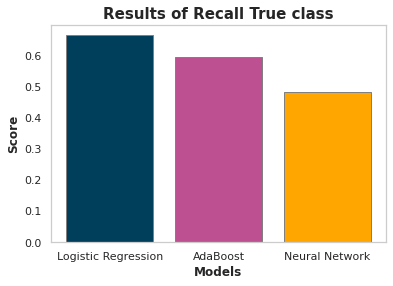

In [52]:
vals = [i[1] for i in sorted_recall]
models = [i[0] for i in sorted_recall]

plt.bar(br1, vals, color =['#003f5c', '#bc5090', '#ffa600'], edgecolor ='grey')
 
# Adding Xticks
plt.title('Results of Recall True class', fontweight ='bold', fontsize = 15)
plt.xlabel('Models', fontweight ='bold', fontsize = 12)
plt.ylabel('Score', fontweight ='bold', fontsize = 12)
plt.xticks([r for r in range(len(true_recall))], models)

plt.grid(color='w', linestyle='solid')
plt.show()

We will also look at the accuracy scores of the models (sorted):

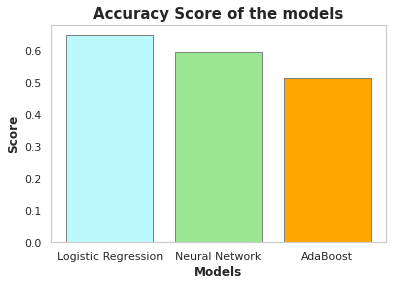

In [53]:
vals = [i[1] for i in sorted_acc_score]
models = [i[0] for i in sorted_acc_score]

bar = plt.bar(br1, vals, color =['#bafaff', '#9be692', '#ffa600'], edgecolor ='grey')
# Adding Xticks
plt.title('Accuracy Score of the models', fontweight ='bold', fontsize = 15)
plt.xlabel('Models', fontweight ='bold', fontsize = 12)
plt.ylabel('Score', fontweight ='bold', fontsize = 12)
plt.xticks([r for r in range(len(true_recall))], models)

plt.grid(color='w', linestyle='solid')
plt.show()

The acuracy score of the models also very close and not so good score...

At this point, we are stopping. We expected to get better models than those. We want to understand why our models are not performing better. 

So, lets have a look at our data to understand him better. We will show a visualization of the data in 2D & 3D:

In [54]:
X_train_later[0]

array([0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 27.0, 23.3578128720529, True, 141,
       59, 4, False, 2, True, 88.92, 0.84, False, False, 75, False, False,
       False, False, True, 175, 115, 58, 199, 24.51, 25.886968969051104,
       True, 2], dtype=object)

In [55]:
# Preprocess data for visualizations:
sc2 = StandardScaler()
x = sc2.fit_transform(X_train_later)
data_by_pca = PCA().fit_transform(x)
col_names = ['1', '2', '3']

# For 2D part:
df_2D = pd.DataFrame(data=data_by_pca[:, :2], columns=col_names[:2])
df_2D["Label"] = y_train
# Selecting rows based on condition:
true_label_2D = df_2D[df_2D["Label"]==1]
false_label_2D = df_2D[df_2D["Label"]==0]

# For 3D part:
df_3D = pd.DataFrame(data=data_by_pca[:, :3], columns=col_names)
df_3D["Label"] = y_train
# Selecting rows based on condition:
true_label_3D = df_3D[df_3D["Label"]==1]
false_label_3D = df_3D[df_3D["Label"]==0]

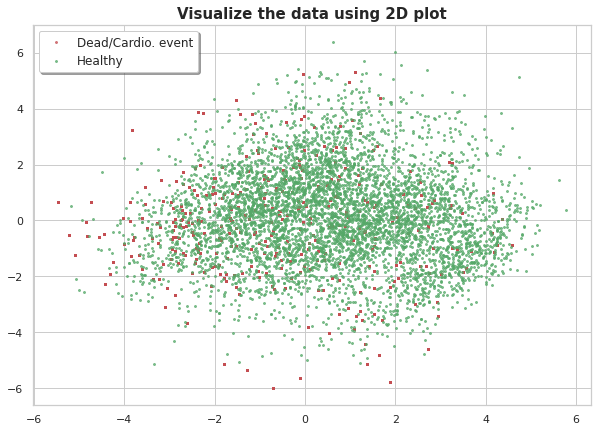

In [56]:
# 2D Visualization:

# Data:
x_true, y_true = true_label_2D["1"], true_label_2D["2"]
x_false, y_false = false_label_2D["1"], false_label_2D["2"]

plt.figure(figsize=(10,7))
plt.scatter(x_true, y_true, label="Dead/Cardio. event", 
            color='r', marker=".", alpha=0.7, s=15)
plt.scatter(x_false, y_false, label="Healthy", 
            color='g', marker=".", alpha=0.7, s=15)

plt.legend(labels = ['Dead/Cardio. event','Healthy'], fontsize=12, shadow=True)
plt.title('Visualize the data using 2D plot', fontweight ='bold', fontsize = 15)
plt.show()

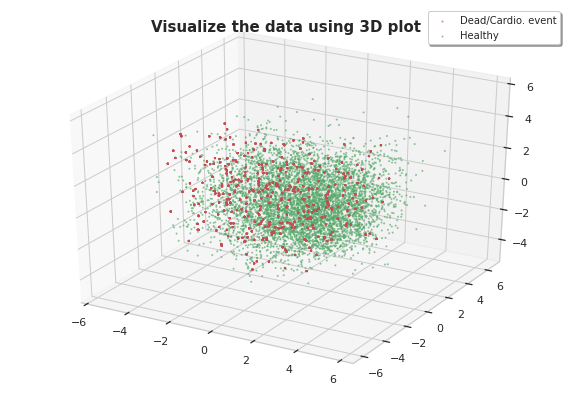

In [57]:
# 3D Visualization:

# Data:
x_true, y_true, z_true = true_label_3D["1"], true_label_3D["2"], true_label_3D["3"]
x_false, y_false, z_false = false_label_3D["1"], false_label_3D["2"], false_label_3D["3"]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

 
ax.scatter(x_true, y_true, z_true, label="Dead/Cardio. event", 
            color='r', marker=".", alpha=0.5, s=5)
ax.scatter(x_false, y_false, z_false, label="Healthy", 
            color='g', marker=".", alpha=0.5, s=5)

plt.title('Visualize the data using 3D plot', fontweight ='bold', fontsize = 15)
ax.legend(labels = ['Dead/Cardio. event','Healthy'], fontsize=10, shadow=True, loc='best')
plt.show()

As we can see from the two plots, our data is relatively centralized (probably due to the standardize).

#Summary

We tried to create 3 models that could classify a patients label, and we got overfitting models. We saw some different measures that tested during the way,  but from the last part (visualization in different dimensions), we understand that our data effected the way the models tryig to predict the correct label for the data samples. To get a good classifier for this data (relatively centralized), it is pretty clear now why the model are tend to be overfitting, and this is why it is so hard to change their tending and getting models without overfit.